In [5]:
%load_ext autoreload
%autoreload 2

import plotly
import plotly.express as px

from WaterClassification.Fitting import *
from WaterClassification.common import *

from RadiometryTrios import RadiometryDB, BaseRadiometry

# from WaterClassification.Radiometry import RadiometryDB
from pathlib import Path
from functools import partial
from itertools import product

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Baseline

This notebook has the objective to establish a baseline to compare further inversion algorithms. <br>
The basic assumptions are:
* Two models will be created. One using high and low SPM separation, and another one adjusting one model for each Area (Basin)
* In the high/low model the SPM concentration will define which formula to use. As the SPM is not known beforehand, another wavelenght (from the satellite possibilities) will be used as a proxy.
* In the Area model, a formula will be calculated for each different Area/Basin
* The bands to be searched will be those from <b>SENTINEL 3</b>
* We will try to fit original and normalized Bands

## Load the database
First we will load the database and clean unwanted Flags

In [6]:
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')
# db.update_metadata(attrs=RadiometryDB.default_attrs)
# db.create_summary_radiometries()

db.load_radiometries(r_types=['Rrs', 'Rrs_OSOAA'], 
                     norm=True,                                                      # create the normalized bands and also the area
                     funcs=partial(BaseRadiometry.calc_area, col_name='flatness', norm_band='700'),  # create the flatness band
                     qry="SPM > 0 and Status == 'Ok'"                            # clear deleted and no data
                    )

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


In [7]:
rrs = db.rdmtries['Rrs']
rrs

Area_2 Station_2    Measurement         Start_Date_2  SPM_2 Status_2  \
Id                                                                            
0     Paranoa   Ponto_1  20160318-1139  2016-03-18 11:39:00    7.0       Ok   
1     Paranoa   Ponto_2  20160318-1214  2016-03-18 12:14:00    8.4       Ok   
2     Paranoa   Ponto_3  20160318-1228  2016-03-18 12:28:00    5.8       Ok   
3     Paranoa   Ponto_4  20160318-1325  2016-03-18 13:25:00    6.2       Ok   
4     Paranoa   Ponto_5  20160318-1347  2016-03-18 13:47:00    8.4       Ok   
...       ...       ...            ...                  ...    ...      ...   
1066   Acudes        P1  20130815-1121  2013-08-15 11:21:29   14.0       Ok   
1067   Acudes        P2  20130815-1200  2013-08-15 12:00:24   16.0       Ok   
1068   Acudes        P3  20130815-1312  2013-08-15 13:12:48   11.2       Ok   
1069   Acudes        P4  20130815-1512  2013-08-15 15:12:50    7.0       Ok   
1070   Acudes        P5  20130815-1532  2013-08-15 15:32:39    7.8       Ok   

           Description_2  319       320       321  ...      n943      n944  \
Id                                                 ...                       
0     GIANCARLO_ CAMP1_1  NaN  0.003272  0.003054  ...  0.000138  0.000127   
1     GIANCARLO_ CAMP1_2  NaN  0.002663  0.002460  ...  0.000193  0.000212   
2     GIANCARLO_ CAMP1_3  NaN  0.003356  0.003116  ...  0.000143  0.000146   
3     GIANCARLO_ CAMP1_4  NaN  0.003155  0.002964  ...  0.000190  0.000192   
4     GIANCARLO_ CAMP1_5  NaN  0.001636  0.001477  ...  0.000184  0.000185   
...                  ...  ...       ...       ...  ...       ...       ...   
1066       20130815-1121  NaN  0.006248  0.006297  ...  0.000223  0.000219   
1067       20130815-1200  NaN  0.006316  0.006360  ...  0.000265  0.000267   
1068       20130815-1312  NaN  0.005552  0.005605  ...  0.000199  0.000194   
1069       20130815-1512  NaN  0.006404  0.006332  ...  0.000197  0.000172   
1070       20130815-1532  NaN  0.006482  0.006421  ...  0.000207  0.000211   

          n945      n946      n947      n948      n949      n950  n951  \
Id                                                                       
0     0.000149  0.000184  0.000180  0.000186  0.000191  0.000213   NaN   
1     0.000206  0.000210  0.000192  0.000204  0.000186  0.000189   NaN   
2     0.000142  0.000146  0.000158  0.000165  0.000162  0.000154   NaN   
3     0.000192  0.000200  0.000200  0.000206  0.000201  0.000198   NaN   
4     0.000192  0.000192  0.000182  0.000179  0.000190  0.000186   NaN   
...        ...       ...       ...       ...       ...       ...   ...   
1066  0.000215  0.000214  0.000211  0.000208  0.000205  0.000202   NaN   
1067  0.000265  0.000254  0.000257  0.000256  0.000245  0.000233   NaN   
1068  0.000186  0.000192  0.000186  0.000175  0.000175  0.000181   NaN   
1069  0.000179  0.000158  0.000199  0.000201  0.000216  0.000193   NaN   
1070  0.000219  0.000217  0.000190  0.000185  0.000196  0.000205   NaN   

      flatness  
Id              
0    -1.480905  
1    -1.484569  
2    -1.755808  
3    -1.554886  
4    -3.310058  
...        ...  
1066 -3.947645  
1067 -5.056455  
1068 -3.666898  
1069 -1.859690  
1070 -1.425889  

[914 rows x 1289 columns]

In [8]:
# deleting outliers
rrs.drop(index=[410, 418, 390, 520, 409, 658], inplace=True, errors='ignore')
len(rrs)

909

## Preparing Bands and Columns

In [9]:
ratios = [f'b{b1}/b{b2}' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + ratios
len(fit_bands)

65

## Separating Calibration and Validation sets

In [10]:
from sklearn.model_selection import train_test_split

# testar o que ocorre com random states 0 e 1
rrs_train, rrs_test = train_test_split(rrs, train_size=0.8, random_state=0)

# One Model for Each Area/Basin

In [28]:
gfit = GroupFit(rrs_train, fit_bands, BaseFit.available_funcs, 'Area', metric=BaseFit.rmsle, thresh=10, n_cpus=6, optimize_metric=True)

In [29]:
gfit.summary()

func       band     R^2         MSE      RMSE  \
Acudes                    Power        783  0.8060     12.3148    3.5092   
Amazon_Floodplains       Linear        740  0.5736     82.2180    9.0674   
Madeira                  Nechad  b740/b705  0.8510  12988.0215  113.9650   
Maroni              Exponential        705  0.8840      9.5533    3.0908   
Mekong                   Nechad  b842/b490  0.9907    117.0387   10.8184   
Negro                     Power        665  0.6196      7.9338    2.8167   
Paranapanema              Power  b705/b560  0.9355      9.5208    3.0856   
Paranoa                   Power        783  0.7884      5.9895    2.4473   
Purus                     Power        705  0.8798   1479.8669   38.4690   
Sao_Francisco       Exponential  b705/b560  0.8910    651.3964   25.5225   
Solimoes_Amazonas   Exponential  b783/b665  0.7569   1143.5868   33.8170   
Ucayali                   Power  b740/b705  0.8859  14311.2091  119.6295   
Volta                     Power  b783/b665  0.9634   1524.8152   39.0489   
overall                     NaN        NaN  0.9438   3499.3185   59.1550   

                     RMSLE           SSE  \
Acudes              0.3962  5.295360e+02   
Amazon_Floodplains  0.2528  8.221795e+02   
Madeira             0.2105  1.779359e+06   
Maroni              0.0901  4.203431e+02   
Mekong              0.1587  1.521504e+03   
Negro               0.5811  9.758530e+02   
Paranapanema        0.3187  3.332289e+02   
Paranoa             0.4046  5.270762e+02   
Purus               0.2998  4.143627e+04   
Sao_Francisco       0.2939  5.015753e+04   
Solimoes_Amazonas   0.3128  8.233825e+04   
Ucayali             0.2021  5.581372e+05   
Volta               0.1453  2.744667e+04   
overall             0.3554  2.544005e+06   

                                                               params  qty  
Acudes              [4533.647154004861, 1.1341937418715595, 1.6302...   43  
Amazon_Floodplains             [1672.972606450853, 4.470344770861471]   10  
Madeira             [38.18545172400212, 3.1488301068200144, -27.77...  137  
Maroni                        [554.7532518489629, -554.0664351818793]   44  
Mekong              [23.36720021540766, 10.34231469407934, 4.45708...   13  
Negro               [5128.301443300472, 1.4103401025743407, 1.2569...  123  
Paranapanema        [24.24817043751716, 2.2644678054435827, -0.300...   35  
Paranoa             [600.5176312575954, 0.7388618603558884, -0.194...   88  
Purus               [27106.811949478768, 1.9558354594097491, 5.097...   28  
Sao_Francisco                [4.310414745214976, -4.6287386772240104]   77  
Solimoes_Amazonas             [57.23995885828187, -82.10719498882453]   72  
Ucayali             [1974.3127956222575, 7.177428059108509, 178.45...   39  
Volta               [527.4501819421057, 2.540522278098515, -15.838...   18  
overall                                                          None    0

<b>OBS:</b> The problem with this approach is that many basins that had less than 10 points were discarded

In [55]:
gfit.calc_test_metric(rrs_test)

{R^2: 0.9529,
 MSE: 5297.3678,
 RMSE: 72.783,
 RMSLE: 0.4277,
 SSE: 964120.9316,
 'params': None}

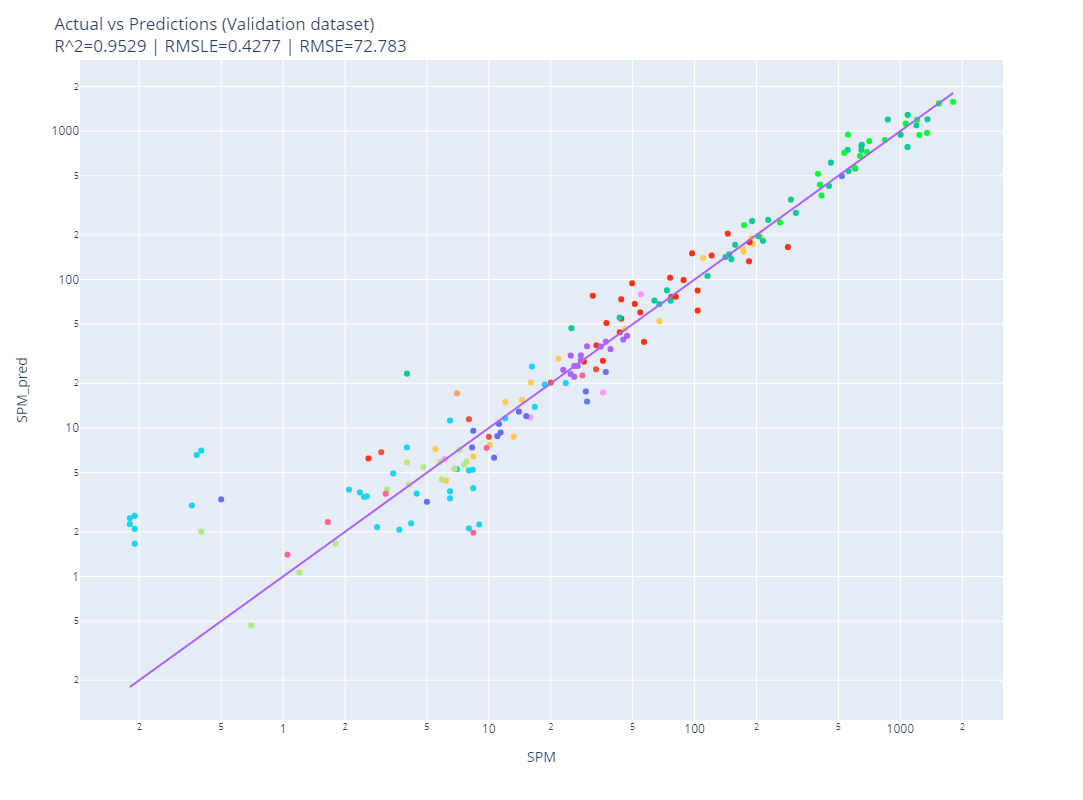

In [66]:
gfit.plot_pred_vs_targ(test_df=rrs_test, title='Actual vs Predictions (Validation dataset)', log_y=True, log_x=True, height=800)

# One model for High and Low concentration

## Defining the PROXY band
The problem with the aforementioned result is that we don't know beforehand the SPM value to "choose" the correct model to use. Instead, we should define a cutoff band/value for this. Considering we are using S3 satellite, we shall test it's bands for a good combination.

### Warning: This step takes a long time to execute

In [67]:
proxy_bands = s2bands
str(proxy_bands)

"['443', '490', '560', '665', '705', '740', '783', '842', '865', '940']"

In [105]:
import dill

def test_cutoff_value(df, cutoff_band, fit_bands, fit_funcs, n_tests=5):
    # tests the cutoff value for a dataset and a given band. 
    # The values to be tested will be retrieved from the percentiles of the bands series. 
    # n_tests is the number of percentiles used for testing
    # if n_tests = 1, just the middle point (0.5) will be tested
    # The results will be a list with the test results
    
    # listify the fit bands and funcs
    fit_bands, fit_funcs = listify(fit_bands, fit_funcs)
    
    # as the "cutoff_band" may be an expression, we will parse it beforehand
    parsed_band = BaseFit.parse_expr_df(df, cutoff_band)
    
    # get the percentiles to be tested and corresponding values
    percentiles = np.linspace(0, 1, n_tests + 2)[1: -1]
    testing_values = [parsed_band.quantile(q) for q in percentiles]
    
    print(f'Testing band {cutoff_band}:')
    
    results = {}
    for cutoff, quantile in zip(testing_values, percentiles):
        print(f'calculating error for Quantile:{round(quantile, 3)} CutoffValue: {cutoff:0.3f}')
        
        high = df[parsed_band > cutoff]
        low = df[parsed_band <= cutoff]      
        
        # do the normal fitting for the two datasets
        mfit_high = MultiFit(high, fit_bands, fit_funcs, expr_y='SPM', metric=BaseFit.rmsle)
        mfit_low = MultiFit(low, fit_bands, fit_funcs, expr_y='SPM', metric=BaseFit.rmsle)
        
        result = BaseFit.test_combined_fit([mfit_high.best_fit, mfit_low.best_fit])
        results[quantile] = result
    return results

def save_cutoff_result(band, result_dict, base_path='./'):
    # create a dataframe with the results (quantiles and metrics)
    df = pd.DataFrame(result_dict)
    
    # create a multi_index to add the band
    df.index = pd.MultiIndex.from_product([[band], df.index], names=['band', 'metric'])

    # save to a pickle file, into the specified folder
    fname = Path(base_path)/f'Cutoff_Band_{band}.dill'
    with open(fname.as_posix(), "wb") as dill_file:
        dill_file.write(dill.dumps(df))


In [ ]:
# Loop through the possible bands to serve as proxy
# bands = bands + ['flatness']

# for band in proxy_bands:
#     cutoff_result = test_cutoff_value(rrs_train, band, fit_bands, BaseFit.available_funcs, n_tests=20)
#     save_cutoff_result(band, cutoff_result, base_path='./cutoff_results')
    

In [108]:
df = None
for band in proxy_bands:
    with open(f'./cutoff_results/Cutoff_Band_{band}.dill', "rb") as dill_file:
        band_result = dill.load(dill_file)
        # .read_pickle(f'./cutoff_results/Cutoff_Band_{band}.pickle')
    
    df = band_result if df is None else pd.concat([df, band_result])
df

0.047619      0.095238      0.142857      0.190476  \
band metric                                                           
443  R^2     4.685000e-01  4.686000e-01  4.687000e-01  4.688000e-01   
     MSE     3.307320e+04  3.306710e+04  3.306240e+04  3.305619e+04   
     RMSE    1.818604e+02  1.818436e+02  1.818307e+02  1.818136e+02   
     RMSLE   9.560000e-01  9.337000e-01  9.095000e-01  8.909000e-01   
     SSE     2.404421e+07  2.403978e+07  2.403637e+07  2.403185e+07   
490  R^2     4.685000e-01  4.686000e-01  4.687000e-01  4.688000e-01   
     MSE     3.307299e+04  3.306962e+04  3.306452e+04  3.305703e+04   
     RMSE    1.818598e+02  1.818506e+02  1.818365e+02  1.818159e+02   
     RMSLE   9.595000e-01  9.441000e-01  9.175000e-01  8.862000e-01   
     SSE     2.404406e+07  2.404162e+07  2.403790e+07  2.403246e+07   
560  R^2     4.685000e-01  4.686000e-01  4.687000e-01  4.689000e-01   
     MSE     3.307415e+04  3.307047e+04  3.306496e+04  3.304897e+04   
     RMSE    1.818630e+02  1.818529e+02  1.818377e+02  1.817938e+02   
     RMSLE   9.648000e-01  9.476000e-01  9.195000e-01  8.669000e-01   
     SSE     2.404491e+07  2.404223e+07  2.403823e+07  2.402660e+07   
665  R^2     4.686000e-01  4.687000e-01  4.689000e-01  4.690000e-01   
     MSE     3.307065e+04  3.306350e+04  3.305383e+04  3.304493e+04   
     RMSE    1.818534e+02  1.818337e+02  1.818071e+02  1.817826e+02   
     RMSLE   9.762000e-01  9.682000e-01  9.450000e-01  9.110000e-01   
     SSE     2.404236e+07  2.403716e+07  2.403014e+07  2.402366e+07   
705  R^2     4.686000e-01  4.687000e-01  4.689000e-01  4.691000e-01   
     MSE     3.306958e+04  3.306064e+04  3.305112e+04  3.304136e+04   
     RMSE    1.818504e+02  1.818258e+02  1.817997e+02  1.817728e+02   
     RMSLE   9.871000e-01  9.682000e-01  9.470000e-01  9.280000e-01   
     SSE     2.404158e+07  2.403508e+07  2.402816e+07  2.402107e+07   
740  R^2     4.686000e-01  4.688000e-01  4.690000e-01  8.350000e-01   
     MSE     3.306739e+04  3.305512e+04  3.304366e+04  1.026922e+04   
     RMSE    1.818444e+02  1.818107e+02  1.817791e+02  1.013371e+02   
     RMSLE   9.870000e-01  9.644000e-01  9.466000e-01  9.225000e-01   
     SSE     2.403999e+07  2.403107e+07  2.402274e+07  7.465720e+06   
783  R^2     4.686000e-01  4.688000e-01  4.690000e-01  8.350000e-01   
     MSE     3.306724e+04  3.305508e+04  3.304410e+04  1.027074e+04   
     RMSE    1.818440e+02  1.818106e+02  1.817804e+02  1.013446e+02   
     RMSLE   9.870000e-01  9.655000e-01  9.523000e-01  9.242000e-01   
     SSE     2.403989e+07  2.403104e+07  2.402306e+07  7.466824e+06   
842  R^2     4.686000e-01  4.688000e-01  4.690000e-01  4.692000e-01   
     MSE     3.306802e+04  3.305557e+04  3.304434e+04  3.303532e+04   
     RMSE    1.818461e+02  1.818119e+02  1.817810e+02  1.817562e+02   
     RMSLE   9.813000e-01  9.591000e-01  9.454000e-01  9.206000e-01   
     SSE     2.404045e+07  2.403140e+07  2.402323e+07  2.401668e+07   
865  R^2     4.686000e-01  4.688000e-01  4.690000e-01  4.691000e-01   
     MSE     3.306846e+04  3.305616e+04  3.304531e+04  3.303627e+04   
     RMSE    1.818473e+02  1.818135e+02  1.817837e+02  1.817588e+02   
     RMSLE   9.772000e-01  9.572000e-01  9.402000e-01  9.154000e-01   
     SSE     2.404077e+07  2.403183e+07  2.402394e+07  2.401737e+07   
940  R^2     4.686000e-01  4.688000e-01  4.671000e-01  5.556000e-01   
     MSE     3.307098e+04  3.305913e+04  3.316467e+04  2.765298e+04   
     RMSE    1.818543e+02  1.818217e+02  1.821117e+02  1.662918e+02   
     RMSLE   9.769000e-01  9.585000e-01  9.831000e-01  9.605000e-01   
     SSE     2.404260e+07  2.403399e+07  2.411071e+07  2.010371e+07   

                 0.238095      0.285714      0.333333      0.380952  \
band metric                                                           
443  R^2     4.690000e-01  4.692000e-01  4.694000e-01  4.695000e-01   
     MSE     3.304459e+04  3.303287e+04  3.301863e+04  3.301368e+04   
     RMSE    1.817817e+02  1.817495e+02 

In [109]:
df.index = df.index.swaplevel()

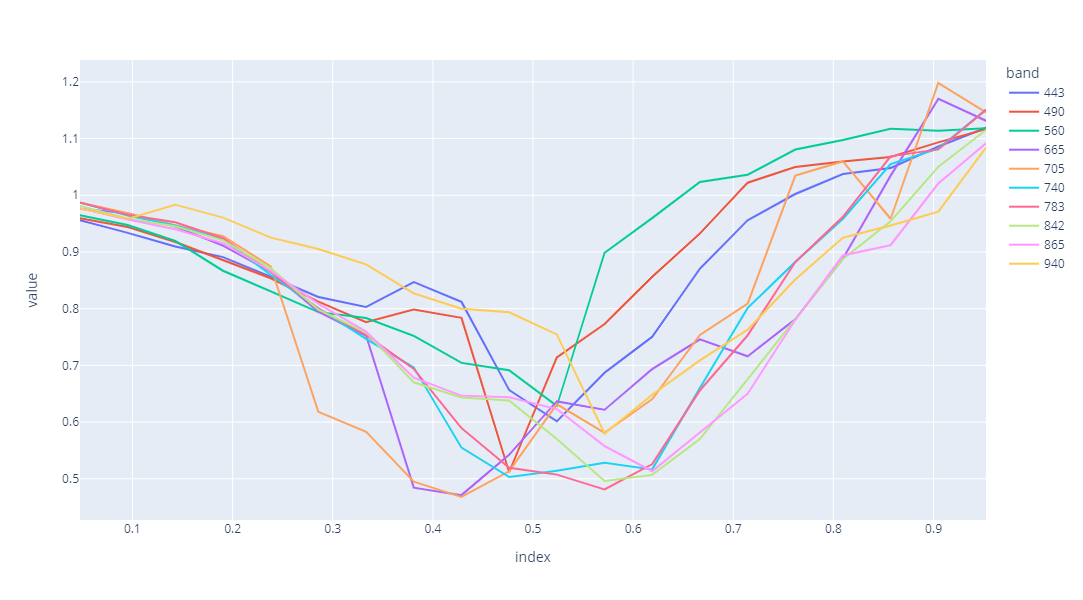

In [145]:
px.line(df.loc['rmsle'].loc[proxy_bands].T, height=600)

## Fitting to Low vs High SPM concentrations 

We know "<i>a priori</i>" that the reflectance curve changes it's shape according to the concentration, so it is not feasible to use just one function for all the SPM range (0 to 1200mg/l), for example. Here is a brief test cutting the dataset into low and high concentrations and testing the overall fitting.

In [11]:
# threshold value
proxy_band = '705'
quantile = 0.428
threshold = rrs_train[proxy_band].quantile(quantile)
threshold

0.015698956046579945

In [12]:
low = rrs[rrs[proxy_band] < threshold]
high = rrs[rrs[proxy_band] >= threshold]

rrs_test_low = rrs_test[rrs_test[proxy_band] < threshold]
rrs_test_high = rrs_test[rrs_test[proxy_band] >= threshold]

In [13]:
mfit_high = MultiFit(high, fit_bands, BaseFit.available_funcs, expr_y='SPM', metric=BaseFit.rmsle, n_cpus=6, optimize_metric=True)

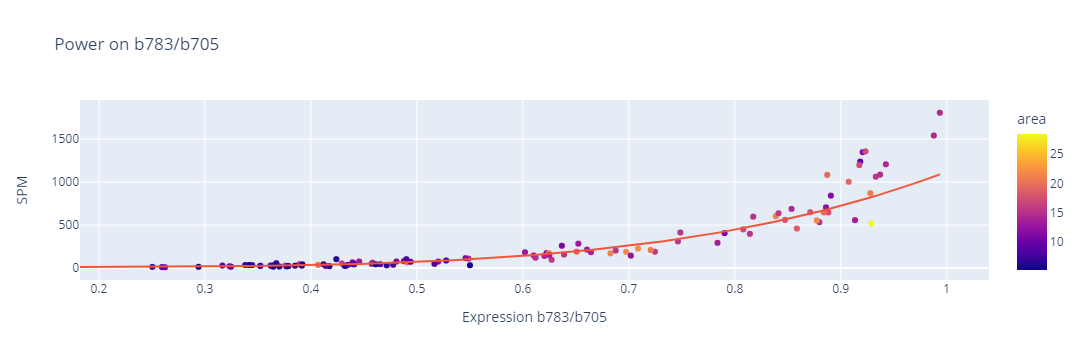

In [14]:
high_fig = mfit_high.plot_best_fit(test_df=rrs_test_high, color='area', update_layout=dict(showlegend=False)) 
high_fig

In [15]:
df_high = mfit_high.summary()
df_high

func       band     R^2      MSE     RMSE   RMSLE  \
Power on b783/b705  Power  b783/b705  0.8435  15433.1   124.23  0.3288   
Power on b740/b705  Power  b740/b705  0.8636  13447.8  115.965  0.3328   
Power on b842/b705  Power  b842/b705  0.8793  11896.6  109.071  0.3381   
Power on b865/b705  Power  b865/b705  0.8848  11352.5  106.548  0.3522   
Power on n865       Power       n865  0.8081  18915.3  137.533  0.3721   

                            SSE  \
Power on b783/b705  8.13323e+06   
Power on b740/b705  7.08701e+06   
Power on b842/b705  6.26949e+06   
Power on b865/b705  5.98276e+06   
Power on n865       9.96836e+06   

                                                               params  qty  
Power on b783/b705  [1106.5099081900507, 4.1918700248420215, 12.31...  527  
Power on b740/b705  [1266.2480238653502, 4.173385204520384, 11.541...  527  
Power on b842/b705  [1429.3645338030965, 2.846238223145871, 11.779...  527  
Power on b865/b705  [1598.645906885199, 2.605290832811507, 12.1476...  527  
Power on n865       [1078576762850.4451, 3.3544390223530396, 17.01...  527

In [16]:
mfit_low = MultiFit(low, fit_bands, BaseFit.available_funcs, expr_y='SPM', metric=BaseFit.rmsle, n_cpus=6, optimize_metric=True)

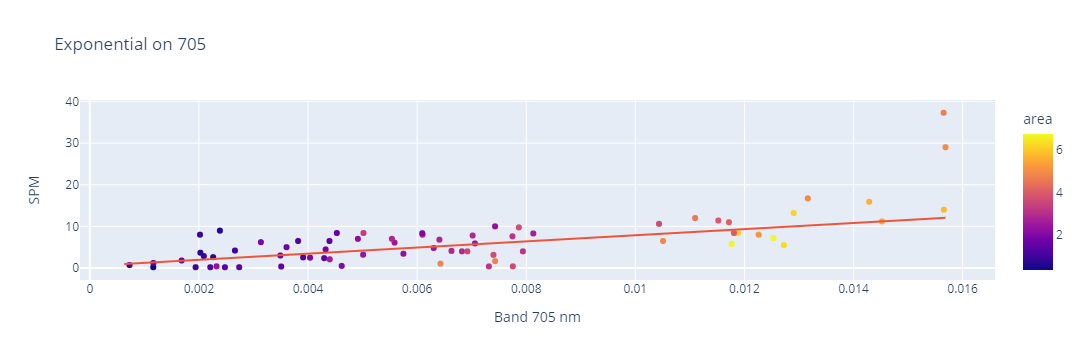

In [17]:
low_fig = mfit_low.plot_best_fit(test_df=rrs_test_low, color='area', update_layout=dict(showlegend=False))
low_fig

In [18]:
df_low = mfit_low.summary()
df_low

func band     R^2      MSE    RMSE   RMSLE  \
Exponential on 705  Exponential  705  0.4257  16.0246  4.0031  0.5496   
Linear on 705            Linear  705  0.4242  16.0663  4.0083  0.5497   
Nechad on 705            Nechad  705  0.4242  16.0663  4.0083  0.5497   
Power on 665              Power  665  0.3058  19.3714  4.4013  0.5906   
Linear on 665            Linear  665  0.3092  19.2775  4.3906  0.5915   

                        SSE  \
Exponential on 705   6121.4   
Linear on 705       6137.31   
Nechad on 705       6137.31   
Power on 665        7399.89   
Linear on 665       7363.99   

                                                               params  qty  
Exponential on 705            [314.5920811752404, -314.1168011176719]  382  
Linear on 705                [733.6264355835848, 0.46023884740935117]  382  
Nechad on 705       [233.52050052030143, -522667604744.4148, 0.460...  382  
Power on 665        [290.2269090298021, 0.8243045128364469, 0.0935...  382  
Linear on 665                 [594.9119230561934, 0.6664887511993886]  382

In [19]:
BaseFit.test_combined_fit([mfit_high.best_fit, mfit_low.best_fit])

{R^2: 0.8765, MSE: 8954.1856, RMSE: 94.6266, RMSLE: 0.4354, SSE: 8139354.6711}

In [20]:
df_high

func       band     R^2      MSE     RMSE   RMSLE  \
Power on b783/b705  Power  b783/b705  0.8435  15433.1   124.23  0.3288   
Power on b740/b705  Power  b740/b705  0.8636  13447.8  115.965  0.3328   
Power on b842/b705  Power  b842/b705  0.8793  11896.6  109.071  0.3381   
Power on b865/b705  Power  b865/b705  0.8848  11352.5  106.548  0.3522   
Power on n865       Power       n865  0.8081  18915.3  137.533  0.3721   

                            SSE  \
Power on b783/b705  8.13323e+06   
Power on b740/b705  7.08701e+06   
Power on b842/b705  6.26949e+06   
Power on b865/b705  5.98276e+06   
Power on n865       9.96836e+06   

                                                               params  qty  
Power on b783/b705  [1106.5099081900507, 4.1918700248420215, 12.31...  527  
Power on b740/b705  [1266.2480238653502, 4.173385204520384, 11.541...  527  
Power on b842/b705  [1429.3645338030965, 2.846238223145871, 11.779...  527  
Power on b865/b705  [1598.645906885199, 2.605290832811507, 12.1476...  527  
Power on n865       [1078576762850.4451, 3.3544390223530396, 17.01...  527

In [33]:
# creating a multiindex for the results
df_high.index = pd.MultiIndex.from_product([['High'], df_high.index], names=['Group', 'Model'])

df_low.index = pd.MultiIndex.from_product([['Low'], df_low.index], names=['Group', 'Model'])

In [36]:
df = pd.concat([df_low, df_high], axis=0)
df

func       band     R^2      MSE     RMSE  \
Group Model                                                                  
Low   Exponential on 705  Exponential        705  0.4257  16.0246   4.0031   
      Linear on 705            Linear        705  0.4242  16.0663   4.0083   
      Nechad on 705            Nechad        705  0.4242  16.0663   4.0083   
      Power on 665              Power        665  0.3058  19.3714   4.4013   
      Linear on 665            Linear        665  0.3092  19.2775   4.3906   
High  Power on b783/b705        Power  b783/b705  0.8435  15433.1   124.23   
      Power on b740/b705        Power  b740/b705  0.8636  13447.8  115.965   
      Power on b842/b705        Power  b842/b705  0.8793  11896.6  109.071   
      Power on b865/b705        Power  b865/b705  0.8848  11352.5  106.548   
      Power on n865             Power       n865  0.8081  18915.3  137.533   

                           RMSLE          SSE  \
Group Model                                     
Low   Exponential on 705  0.5496       6121.4   
      Linear on 705       0.5497      6137.31   
      Nechad on 705       0.5497      6137.31   
      Power on 665        0.5906      7399.89   
      Linear on 665       0.5915      7363.99   
High  Power on b783/b705  0.3288  8.13323e+06   
      Power on b740/b705  0.3328  7.08701e+06   
      Power on b842/b705  0.3381  6.26949e+06   
      Power on b865/b705  0.3522  5.98276e+06   
      Power on n865       0.3721  9.96836e+06   

                                                                     params  \
Group Model                                                                   
Low   Exponential on 705            [314.5920811752404, -314.1168011176719]   
      Linear on 705                [733.6264355835848, 0.46023884740935117]   
      Nechad on 705       [233.52050052030143, -522667604744.4148, 0.460...   
      Power on 665        [290.2269090298021, 0.8243045128364469, 0.0935...   
      Linear on 665                 [594.9119230561934, 0.6664887511993886]   
High  Power on b783/b705  [1106.5099081900507, 4.1918700248420215, 12.31...   
      Power on b740/b705  [1266.2480238653502, 4.173385204520384, 11.541...   
      Power on b842/b705  [1429.3645338030965, 2.846238223145871, 11.779...   
      Power on b865/b705  [1598.645906885199, 2.605290832811507, 12.1476...   
      Power on n865       [1078576762850.4451, 3.3544390223530396, 17.01...   

                          qty  
Group Model                    
Low   Exponential on 705  382  
      Linear on 705       382  
      Nechad on 705       382  
      Power on 665        382  
      Linear on 665       382  
High  Power on b783/b705  527  
      Power on b740/b705  527  
      Power on b842/b705  527  
      Power on b865/b705  527  
      Power on n865       527

In [46]:
total = pd.Series(BaseFit.test_combined_fit([mfit_high.best_fit, mfit_low.best_fit])).rename(('Combined', 'Best Overall'))

In [47]:
df.append(total)

func       band     R^2      MSE     RMSE  \
Group    Model                                                                  
Low      Exponential on 705  Exponential        705  0.4257  16.0246   4.0031   
         Linear on 705            Linear        705  0.4242  16.0663   4.0083   
         Nechad on 705            Nechad        705  0.4242  16.0663   4.0083   
         Power on 665              Power        665  0.3058  19.3714   4.4013   
         Linear on 665            Linear        665  0.3092  19.2775   4.3906   
High     Power on b783/b705        Power  b783/b705  0.8435  15433.1   124.23   
         Power on b740/b705        Power  b740/b705  0.8636  13447.8  115.965   
         Power on b842/b705        Power  b842/b705  0.8793  11896.6  109.071   
         Power on b865/b705        Power  b865/b705  0.8848  11352.5  106.548   
         Power on n865             Power       n865  0.8081  18915.3  137.533   
Combined Best Overall                NaN        NaN  0.8765  8954.19  94.6266   

                              RMSLE          SSE  \
Group    Model                                     
Low      Exponential on 705  0.5496       6121.4   
         Linear on 705       0.5497      6137.31   
         Nechad on 705       0.5497      6137.31   
         Power on 665        0.5906      7399.89   
         Linear on 665       0.5915      7363.99   
High     Power on b783/b705  0.3288  8.13323e+06   
         Power on b740/b705  0.3328  7.08701e+06   
         Power on b842/b705  0.3381  6.26949e+06   
         Power on b865/b705  0.3522  5.98276e+06   
         Power on n865       0.3721  9.96836e+06   
Combined Best Overall        0.4354  8.13935e+06   

                                                                        params  \
Group    Model                                                                   
Low      Exponential on 705            [314.5920811752404, -314.1168011176719]   
         Linear on 705                [733.6264355835848, 0.46023884740935117]   
         Nechad on 705       [233.52050052030143, -522667604744.4148, 0.460...   
         Power on 665        [290.2269090298021, 0.8243045128364469, 0.0935...   
         Linear on 665                 [594.9119230561934, 0.6664887511993886]   
High     Power on b783/b705  [1106.5099081900507, 4.1918700248420215, 12.31...   
         Power on b740/b705  [1266.2480238653502, 4.173385204520384, 11.541...   
         Power on b842/b705  [1429.3645338030965, 2.846238223145871, 11.779...   
         Power on b865/b705  [1598.645906885199, 2.605290832811507, 12.1476...   
         Power on n865       [1078576762850.4451, 3.3544390223530396, 17.01...   
Combined Best Overall                                                      NaN   

                             qty  
Group    Model                    
Low      Exponential on 705  382  
         Linear on 705       382  
         Nechad on 705       382  
         Power on 665        382  
         Linear on 665       382  
High     Power on b783/b705  527  
         Power on b740/b705  527  
         Power on b842/b705  527  
         Power on b865/b705  527  
         Power on n865       527  
Combined Best Overall        NaN

### Assessing High/Low model in the Validation dataset

In [48]:
rrs_test.loc[rrs_test_low.index, 'SPM_pred'] = mfit_low.best_fit.predict(rrs_test_low)['y_hat']
rrs_test.loc[rrs_test_high.index, 'SPM_pred'] = mfit_high.best_fit.predict(rrs_test_high)['y_hat']

rrs_test['Group'] = rrs_test[proxy_band] < threshold

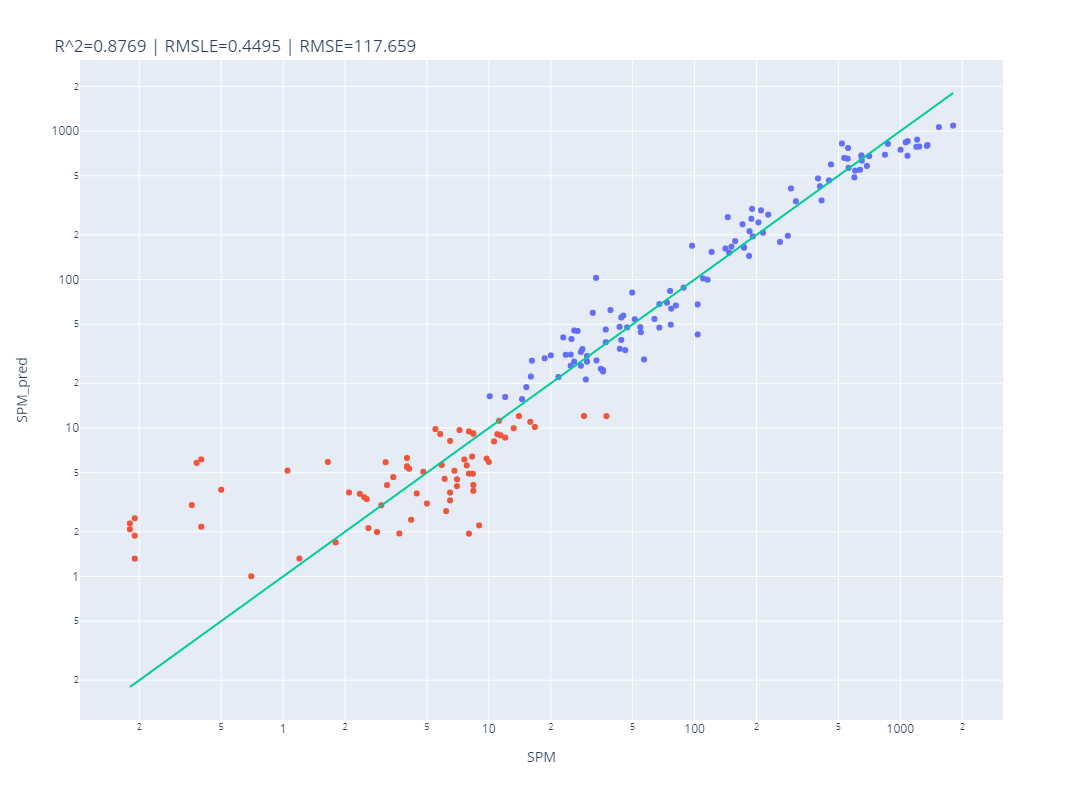

In [49]:
preds_fig = BaseFit.plot_pred_vs_targ(rrs_test, 'SPM', 'SPM_pred', color_group='Group', log_x=True, log_y=True, height=800)
preds_fig

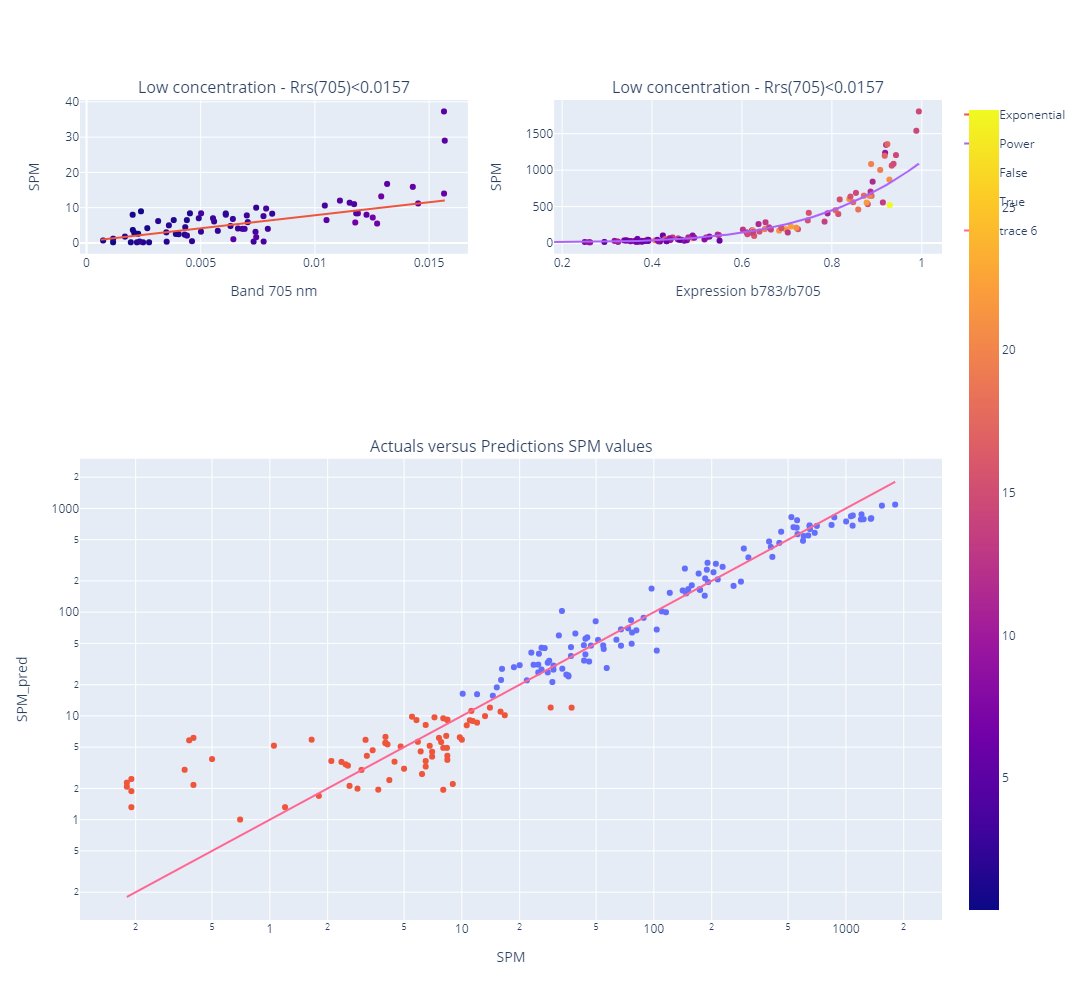

In [50]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from WaterClassification.common import *

fig = make_subplots(rows=2, cols=2, row_heights=[0.25, 0.75],
                    specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("Low concentration - Rrs(705)<0.0157","Low concentration - Rrs(705)<0.0157", "Actuals versus Predictions SPM values"))

apply_subplot(fig, low_fig, position=(1, 1))
apply_subplot(fig, high_fig, position=(1, 2))
apply_subplot(fig, preds_fig, position=(2, 1))

fig.update_layout(height=1000)

## One model for Each Basin

In [52]:
gfit = GroupFit(rrs_train, fit_bands, BaseFit.available_funcs, 'Area', metric=BaseFit.rmsle, thresh=10, n_cpus=6, optimize_metric=True)

In [53]:
gfit.summary()

func       band     R^2         MSE      RMSE  \
Acudes                    Power        783  0.8060     12.3148    3.5092   
Amazon_Floodplains       Linear        740  0.5736     82.2180    9.0674   
Madeira                  Nechad  b740/b705  0.8510  12988.0215  113.9650   
Maroni              Exponential        705  0.8840      9.5533    3.0908   
Mekong                   Nechad  b842/b490  0.9907    117.0387   10.8184   
Negro                     Power        665  0.6196      7.9338    2.8167   
Paranapanema              Power  b705/b560  0.9355      9.5208    3.0856   
Paranoa                   Power        783  0.7884      5.9895    2.4473   
Purus                     Power        705  0.8798   1479.8669   38.4690   
Sao_Francisco       Exponential  b705/b560  0.8910    651.3964   25.5225   
Solimoes_Amazonas   Exponential  b783/b665  0.7569   1143.5868   33.8170   
Ucayali                   Power  b740/b705  0.8859  14311.2091  119.6295   
Volta                     Power  b783/b665  0.9634   1524.8152   39.0489   
overall                     NaN        NaN  0.9438   3499.3185   59.1550   

                     RMSLE           SSE  \
Acudes              0.3962  5.295360e+02   
Amazon_Floodplains  0.2528  8.221795e+02   
Madeira             0.2105  1.779359e+06   
Maroni              0.0901  4.203431e+02   
Mekong              0.1587  1.521504e+03   
Negro               0.5811  9.758530e+02   
Paranapanema        0.3187  3.332289e+02   
Paranoa             0.4046  5.270762e+02   
Purus               0.2998  4.143627e+04   
Sao_Francisco       0.2939  5.015753e+04   
Solimoes_Amazonas   0.3128  8.233825e+04   
Ucayali             0.2021  5.581372e+05   
Volta               0.1453  2.744667e+04   
overall             0.3554  2.544005e+06   

                                                               params  qty  
Acudes              [4533.647154004861, 1.1341937418715595, 1.6302...   43  
Amazon_Floodplains             [1672.972606450853, 4.470344770861471]   10  
Madeira             [38.18545172400212, 3.1488301068200144, -27.77...  137  
Maroni                        [554.7532518489629, -554.0664351818793]   44  
Mekong              [23.36720021540766, 10.34231469407934, 4.45708...   13  
Negro               [5128.301443300472, 1.4103401025743407, 1.2569...  123  
Paranapanema        [24.24817043751716, 2.2644678054435827, -0.300...   35  
Paranoa             [600.5176312575954, 0.7388618603558884, -0.194...   88  
Purus               [27106.811949478768, 1.9558354594097491, 5.097...   28  
Sao_Francisco                [4.310414745214976, -4.6287386772240104]   77  
Solimoes_Amazonas             [57.23995885828187, -82.10719498882453]   72  
Ucayali             [1974.3127956222575, 7.177428059108509, 178.45...   39  
Volta               [527.4501819421057, 2.540522278098515, -15.838...   18  
overall                                                          None    0

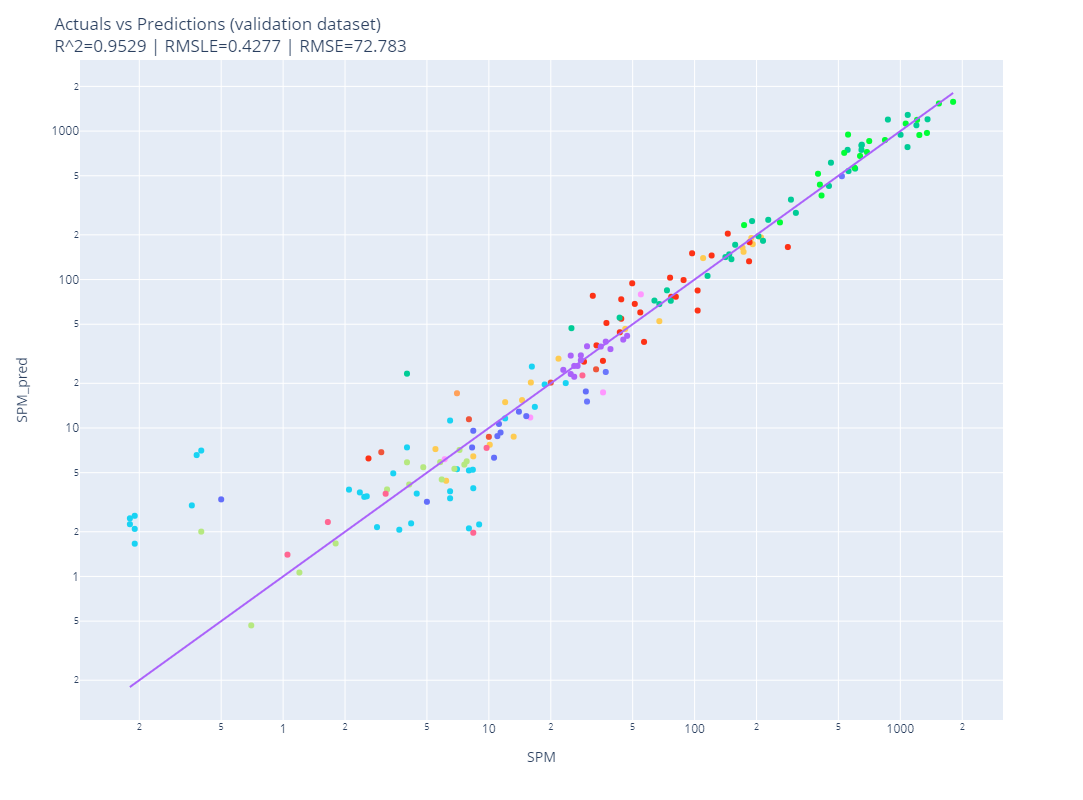

In [60]:
gfit.plot_pred_vs_targ(test_df=rrs_test, log_y=True, log_x=True, height=800,
                       title='Actuals vs Predictions (validation dataset)'
                      )